# Make panels in figure 3 - males vs females

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import seaborn as sns
from aging.plotting import format_plots, save_factory, figure, legend, PlotConfig, add_identity

In [37]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig3-panels", tight_layout=False)

colors = ['#c7eae5','#008C8D']
male_cmap = sns.blend_palette(colors, as_cmap=True)
colors = ['#fee6ce','#d94801']
female_cmap = sns.blend_palette(colors, as_cmap=True)

In [5]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet')
# f_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet')
f_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v{df_version:02d}.parquet')
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = df[keep_syllables]
f_df = f_df[keep_syllables]
df = df.set_index(pd.Index(['male'] * len(df), name='experiment'), append=True)
f_df = f_df.set_index(pd.Index(['female'] * len(f_df), name='experiment'), append=True)
df = pd.concat([df, f_df])

usage_order = df.quantile(0.9).sort_values(ascending=False).index
df = df[usage_order].astype('float32')
df = df.query('age < 100')

## Make panel for male/female "pca"

In [3]:
from sklearn.cross_decomposition import PLSRegression

In [4]:
reg = PLSRegression(n_components=2)
reg.fit(df, df.index.get_level_values('age').to_numpy()[:, None])

PLSRegression()

In [5]:
scores = reg.transform(df)

In [6]:
scores_df = pd.DataFrame(scores, index=df.index)

In [13]:
cmapmap = {
    'male': male_cmap,
    'female': female_cmap,
}

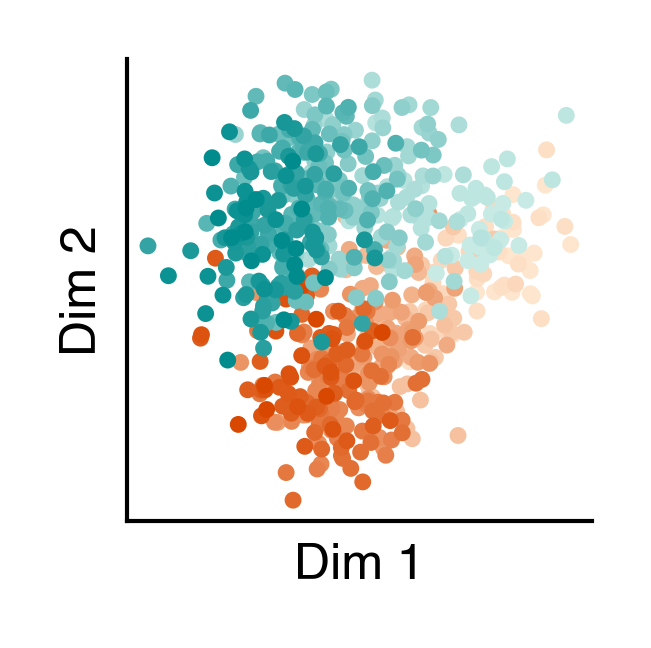

In [22]:
fig = figure(1, 1)
ax = fig.gca()
for experiment, _df in scores_df.groupby('experiment'):
    ax.scatter(_df[0], _df[1], c=_df.index.get_level_values('age'), cmap=cmapmap[experiment], s=1.5)
ax.set(xticks=[], yticks=[], xlabel="Dim 1", ylabel="Dim 2")
sns.despine()
saver(fig, "pls-regression-male-female");

## Female regression

In [24]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import r2_score

In [25]:
female_df = df.query('experiment == "female"')
y = female_df.index.get_level_values("age")

In [28]:
preds = cross_val_predict(
    PLSRegression(n_components=5),
    female_df,
    y.to_numpy()[:, None],
    groups=y,
    cv=LeaveOneGroupOut(),
    n_jobs=-1,
).squeeze()
r2s = r2_score(y, preds)
r2s

0.6003696592259109

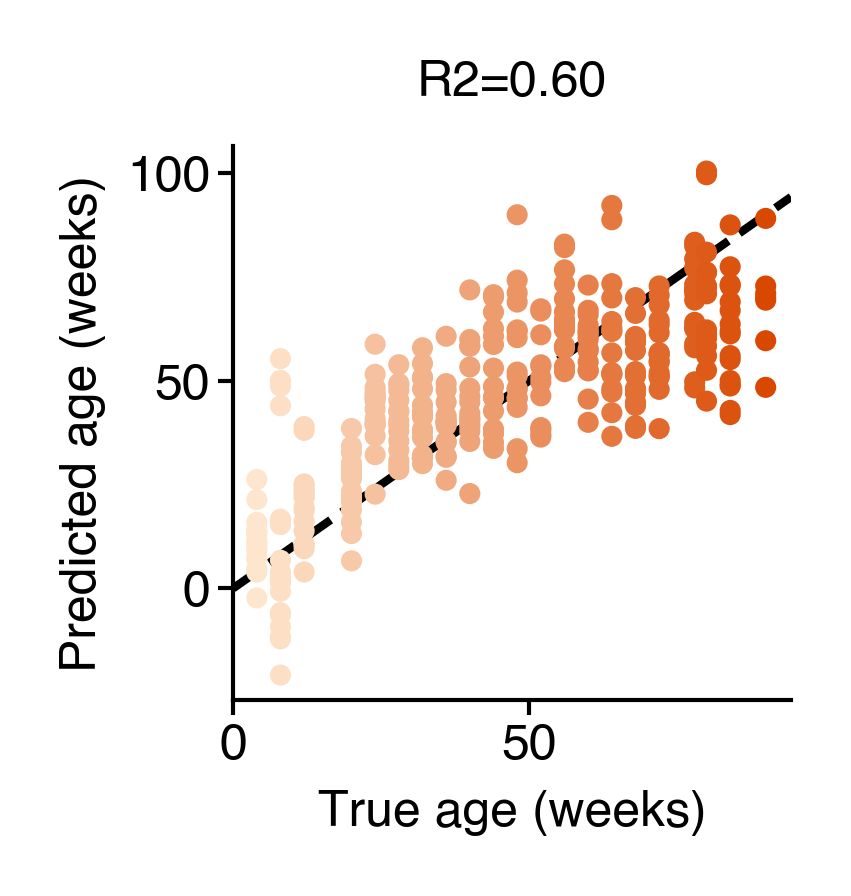

In [32]:
fig = figure(1.2, 1.2)
ax = fig.gca()
plt.scatter(y, preds, c=y, cmap=female_cmap, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None), yticks=[0, 50, 100], xlabel="True age (weeks)", ylabel="Predicted age (weeks)", title=f"R2={r2s:0.2f}")
sns.despine()
saver(fig, "female-chron-age-regression-results-logo");

In [34]:
preds = cross_val_predict(
    PLSRegression(n_components=5),
    female_df,
    y.to_numpy()[:, None],
    groups=y,
    cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
    n_jobs=-1,
).squeeze()
r2s = r2_score(y, preds)
r2s

0.6713601079516727

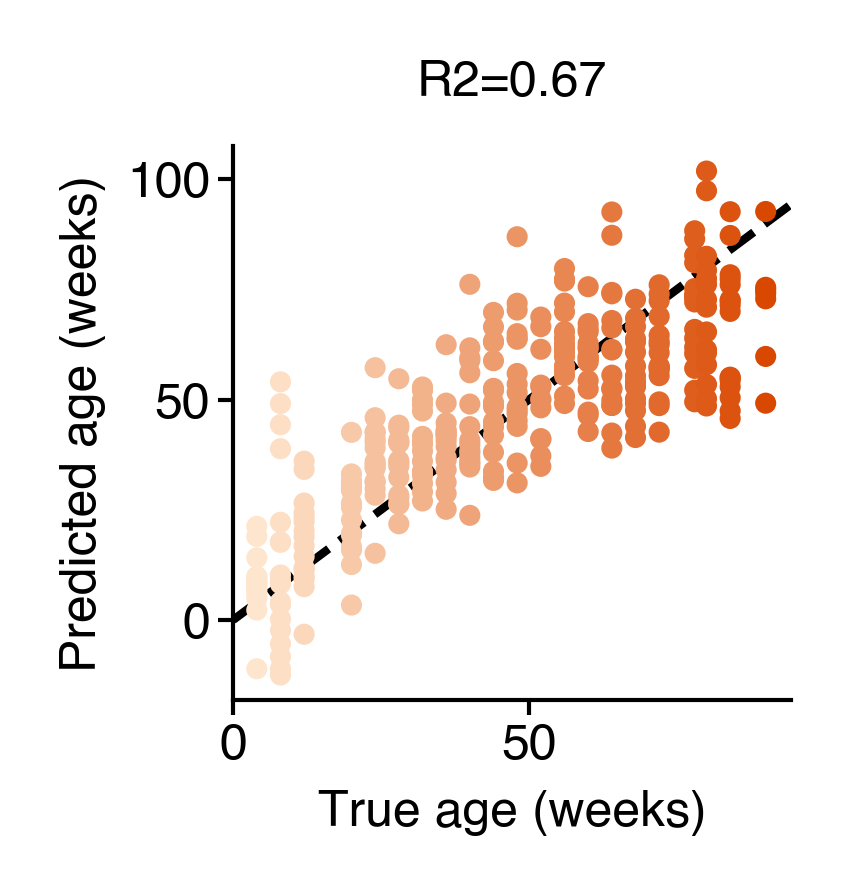

In [35]:
fig = figure(1.2, 1.2)
ax = fig.gca()
plt.scatter(y, preds, c=y, cmap=female_cmap, s=3)
add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None), yticks=[0, 50, 100], xlabel="True age (weeks)", ylabel="Predicted age (weeks)", title=f"R2={r2s:0.2f}")
sns.despine()
saver(fig, "female-chron-age-regression-results-stratified");

## Plot usage based on male ontogeny syllable ordering

In [60]:
plt_order = np.loadtxt("/n/groups/datta/win/longtogeny/data/ontogeny/version_11/onto_male_syllable_plot_order.txt", dtype=int)
plt_order2 = np.loadtxt("/n/groups/datta/win/longtogeny/data/ontogeny/version_11/onto_male_syllable_plot_order_2.txt", dtype=int)

In [39]:
image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

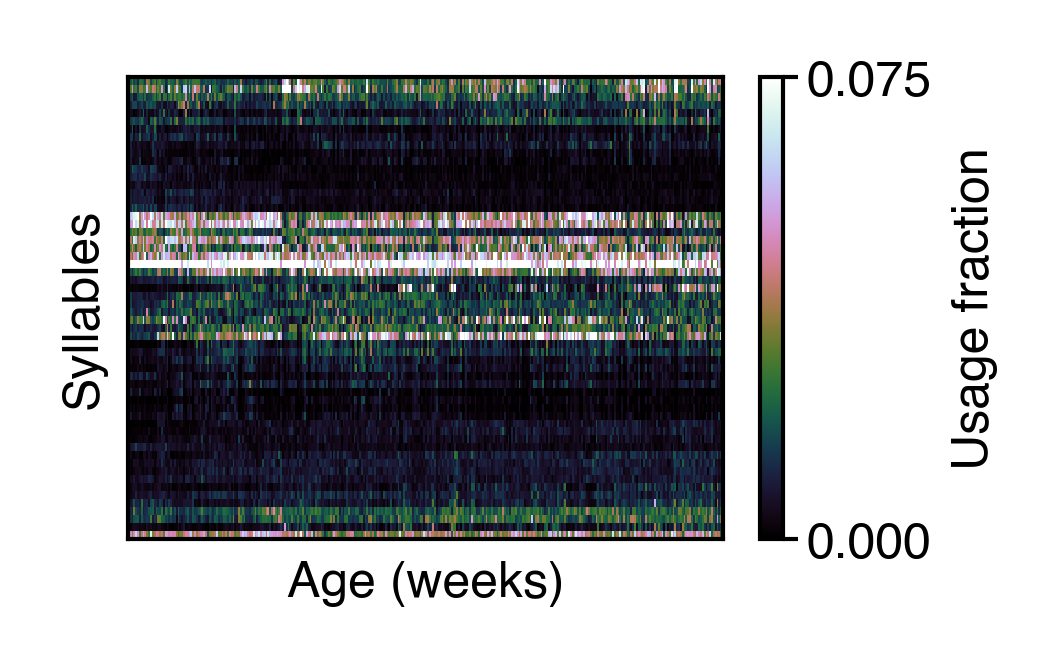

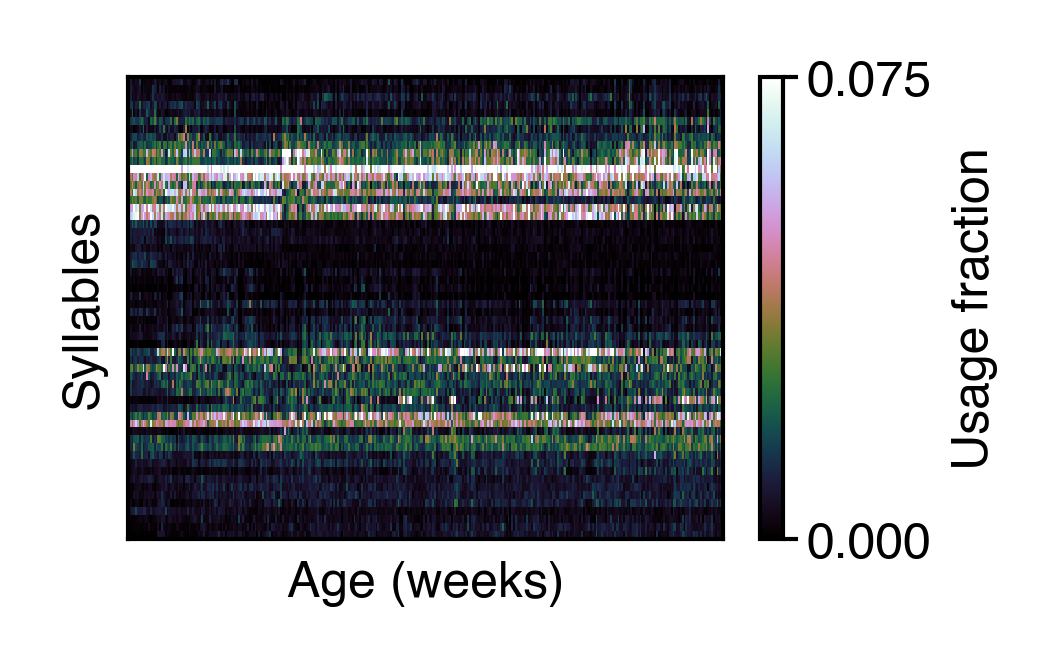

In [43]:
female_df = df.query('experiment == "female"')
ages = female_df.index.get_level_values("age")

for i, _order in enumerate((plt_order, plt_order2)):
    with plt.rc_context(image_ctx):
        fig = figure(1.6, 1)
        ax = fig.gca()
        im = ax.imshow(female_df[_order].T, vmax=0.075, aspect='auto', vmin=0, extent=(ages.min(), ages.max(), len(df.T), 0))
        cb = fig.colorbar(mappable=im, ax=ax, label="Usage fraction")
        cb.set_ticks([0, 0.075])
        ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
    saver(fig, f"female_usage_plot_order-{i:02d}")

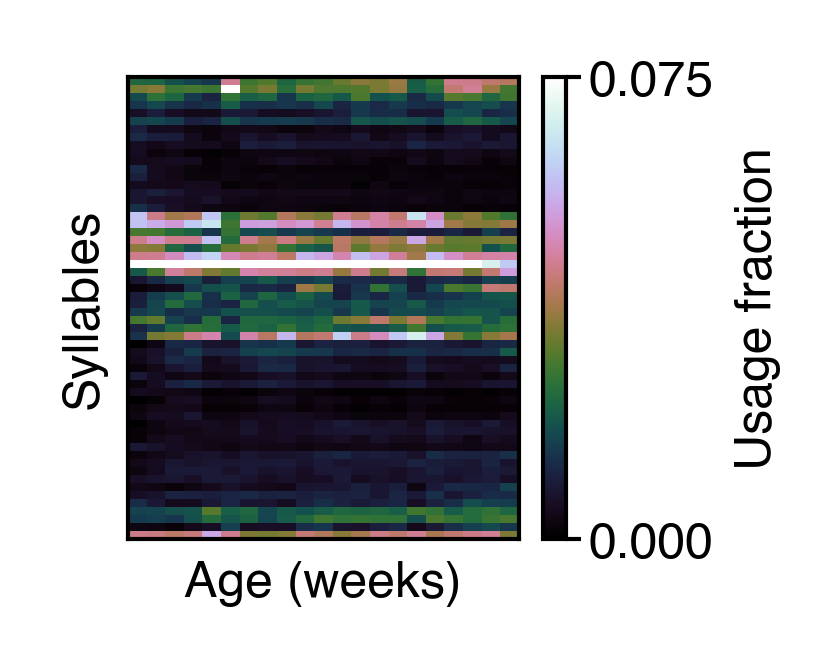

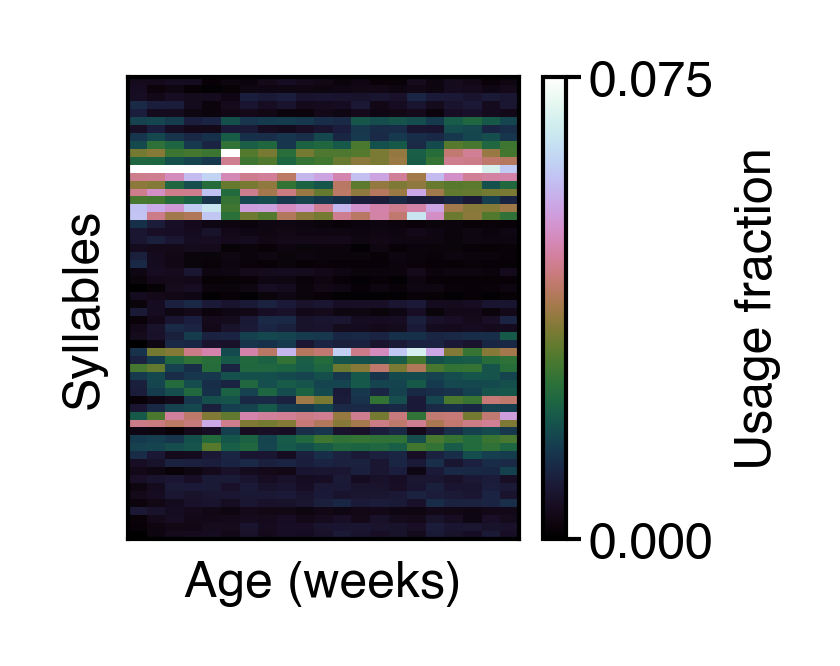

In [61]:
for i, _order in enumerate((plt_order, plt_order2)):
    with plt.rc_context(image_ctx):
        fig = figure(1.05, 1)
        ax = fig.gca()
        im = ax.imshow(female_df.groupby('age').mean()[_order].T, vmax=0.075, aspect='auto', vmin=0, extent=(ages.min(), ages.max(), len(df.T), 0))
        cb = fig.colorbar(mappable=im, ax=ax, label="Usage fraction")
        cb.set_ticks([0, 0.075])
        ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
    saver(fig, f"female_averaged_usage_plot_order-{i:02d}")
    plt.show()

### Do within-female clustering

In [54]:
from sklearn.cluster import KMeans
from functools import reduce
from operator import add

In [44]:
norm_df = female_df - female_df.min()
norm_df = norm_df / norm_df.quantile(0.95)

In [47]:
km = KMeans(n_clusters=4, random_state=0)
lbls = km.fit_predict(norm_df.T)
syll_lbl_df = pd.DataFrame({"syll": df.columns, "lbl": lbls})

In [48]:
# sort syllables by usage within cluster
cluster_avgs = female_df.T.groupby(lbls).mean().T.mean().sort_values(ascending=False)
new_map_order = dict(map(reversed, enumerate(cluster_avgs.index)))
cluster_avgs

2    0.030384
0    0.015370
3    0.011809
1    0.004560
dtype: float32

In [49]:
new_map_order

{2: 0, 0: 1, 3: 2, 1: 3}

In [50]:
df_with_cluster = female_df.T
df_with_cluster = df_with_cluster.set_index(
    [
        pd.Index(lbls, name="labels").map(new_map_order),
        pd.Index(df_with_cluster.index, name="syllables"),
    ]
)

In [55]:
within_clust_org = {}
for i, (l, _df) in enumerate(df_with_cluster.groupby('labels')):
    syllable_order = _df.T.quantile(0.75).index.get_level_values('syllables')
    if i % 2 == 0:
        within_clust_org[l] = list(syllable_order)
    else:
        within_clust_org[l] = list(syllable_order)[::-1]
plt_order = reduce(add, within_clust_org.values())

within_clust_org = {}
for i, (l, _df) in enumerate(df_with_cluster.groupby('labels')):
    syllable_order = _df.T.quantile(0.75).index.get_level_values('syllables')
    if i % 2 == 1:
        within_clust_org[l] = list(syllable_order)
    else:
        within_clust_org[l] = list(syllable_order)[::-1]
plt_order2 = reduce(add, within_clust_org.values())

In [6]:
female_df = df.query('experiment == "female"')
ages = female_df.index.get_level_values("age")

for i, _order in enumerate((plt_order, plt_order2)):
    with plt.rc_context(image_ctx):
        fig = figure(1.6, 1)
        ax = fig.gca()
        im = ax.imshow(female_df[_order].T, vmax=0.075, aspect='auto', vmin=0, extent=(ages.min(), ages.max(), len(df.T), 0))
        cb = fig.colorbar(mappable=im, ax=ax, label="Usage fraction")
        cb.set_ticks([0, 0.075])
        ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
    saver(fig, f"female_usage_plot_order-{i:02d}-female-specific-sort")

NameError: name 'plt_order' is not defined

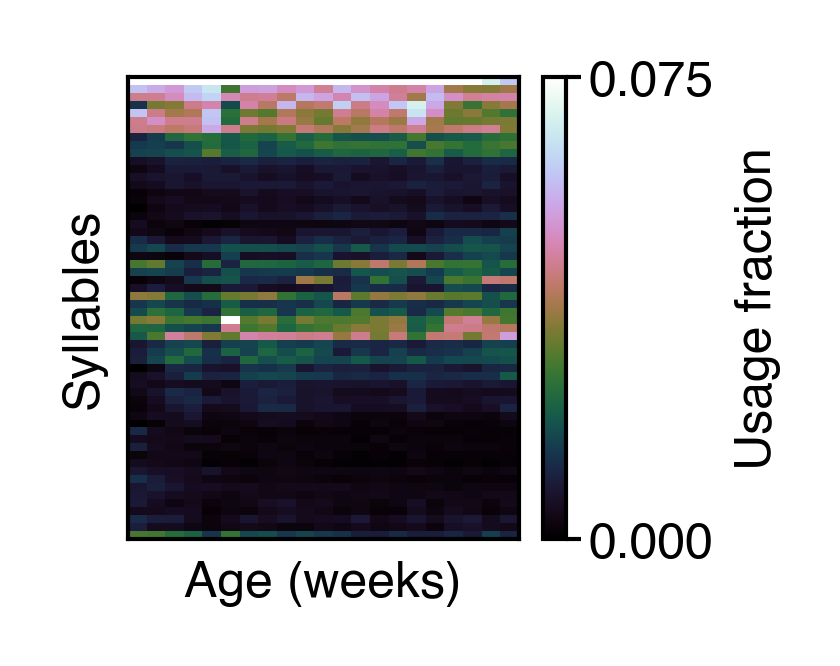

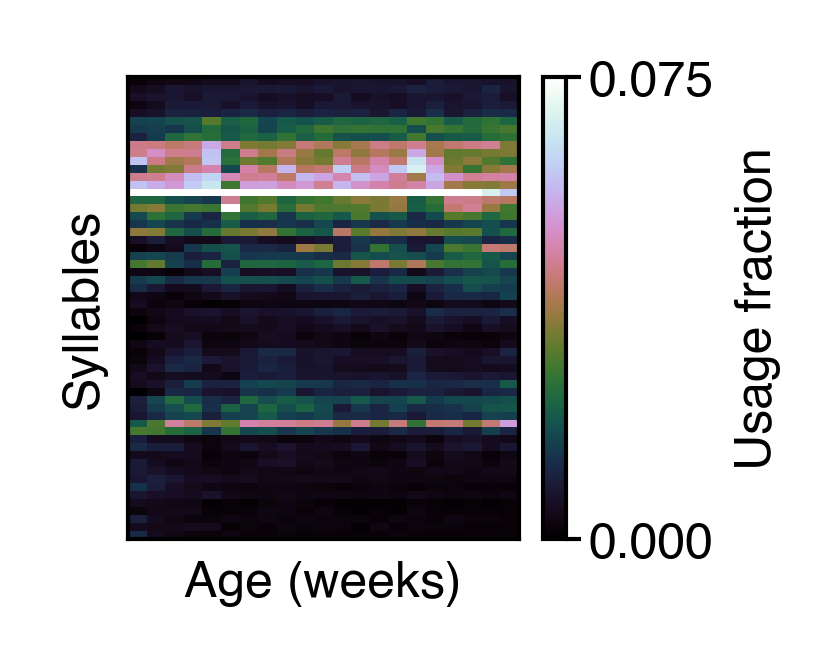

In [59]:
for i, _order in enumerate((plt_order, plt_order2)):
    with plt.rc_context(image_ctx):
        fig = figure(1.05, 1)
        ax = fig.gca()
        im = ax.imshow(female_df.groupby('age').mean()[_order].T, vmax=0.075, aspect='auto', vmin=0, extent=(ages.min(), ages.max(), len(df.T), 0))
        cb = fig.colorbar(mappable=im, ax=ax, label="Usage fraction")
        cb.set_ticks([0, 0.075])
        ax.set(yticks=[], xticks=[], xlabel='Age (weeks)', ylabel="Syllables")
    saver(fig, f"female_averaged_usage_plot_order-{i:02d}-female-specific-sort")

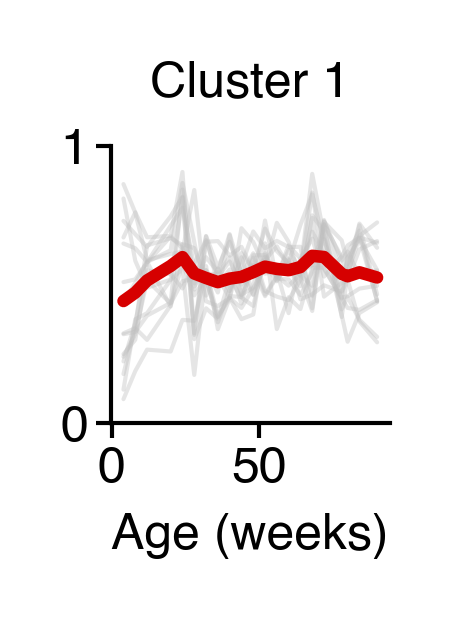

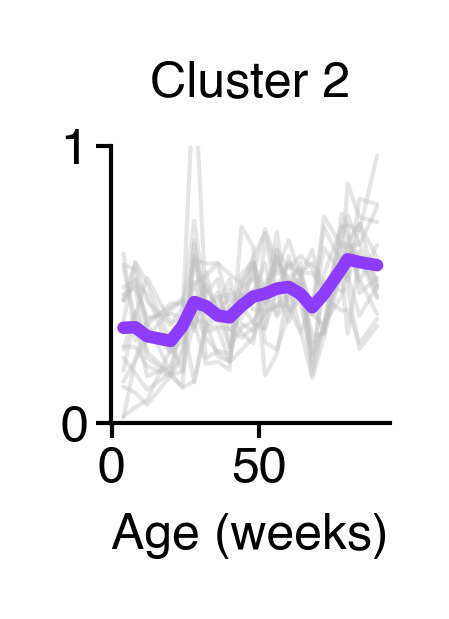

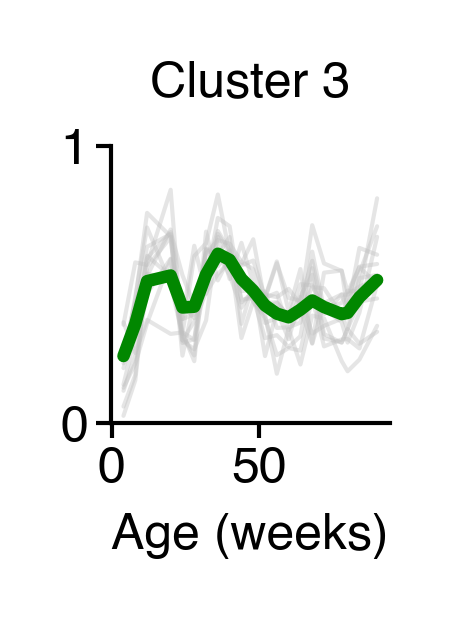

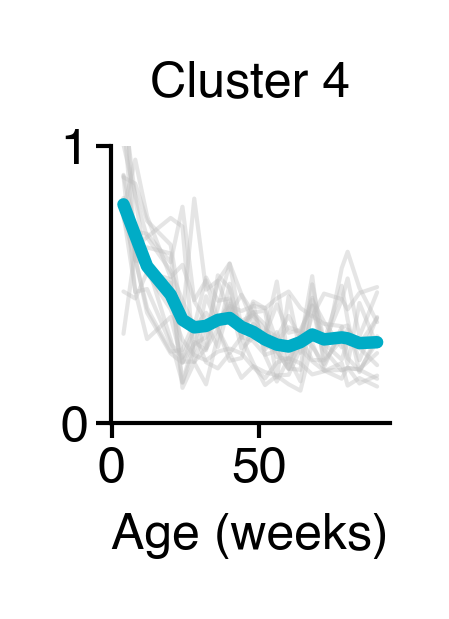

In [58]:
for _lbl, _df in norm_df.T.groupby(list(map(new_map_order.get, lbls))):
    fig = figure(0.6, 0.6)
    ax = fig.gca()
    ax = (
        _df.T.groupby("age")
        .mean()
        .plot(ax=ax, legend=False, color="silver", lw=0.5, alpha=0.4)
    )
    ax.plot(
        _df.T.groupby("age")
        .mean()
        .mean(1)
        .rolling(5, win_type="gaussian", min_periods=1, center=True)
        .mean(std=0.75),
        lw=1.5,
        color=cc.glasbey[_lbl],
    )
    ax.set(ylim=(0, 1), yticks=[0, 1], xlabel="Age (weeks)", title=f"Cluster {_lbl + 1}")
    sns.despine()
    saver(fig, f"females-clustered-usage-cluster-{_lbl}")

## PCA of syllable usage

In [7]:
from sklearn.decomposition import PCA

In [19]:
def zscore(df):
    return (df - df.mean()) / df.std()

def mmn(df):
    m = df.where(df > 0).min()
    ma = df.max()
    return (df - m) / (ma - m)

In [50]:
pcs = PCA(n_components=2).fit_transform(female_df)

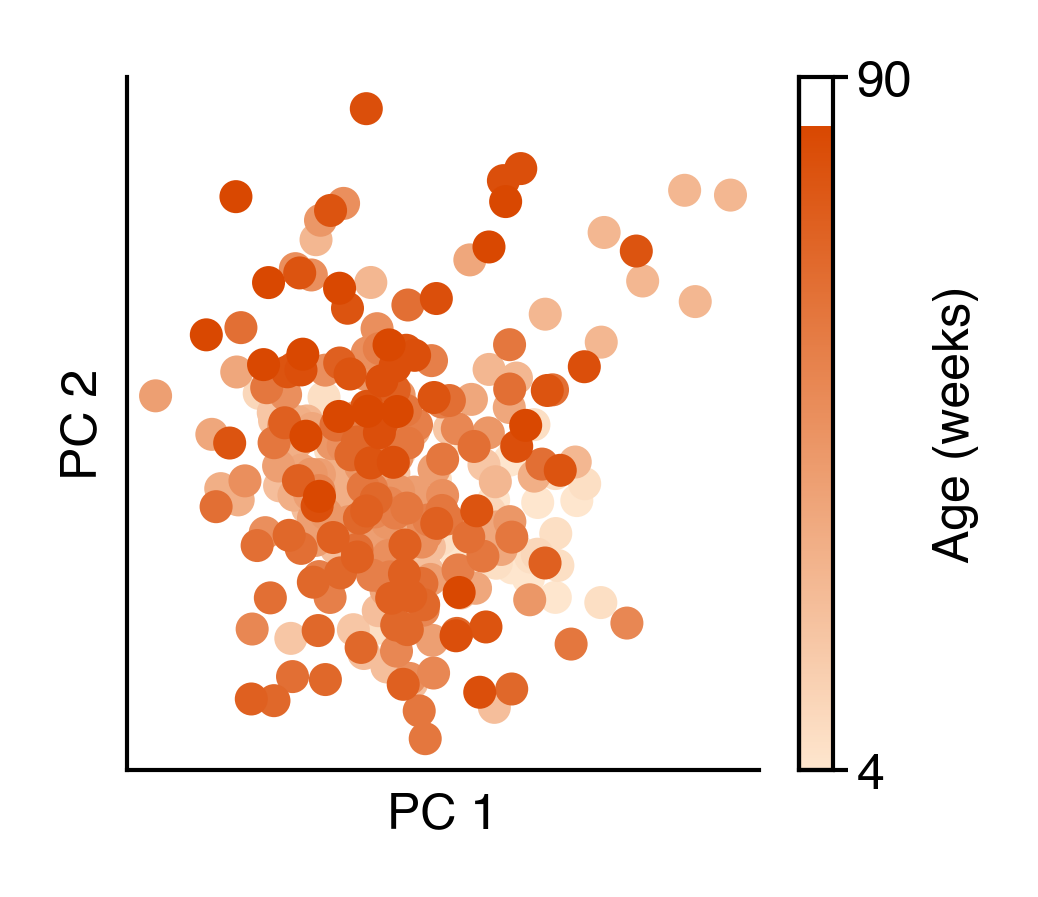

In [52]:
fig = figure(1.7, 1.5)
ax = fig.gca()
im = ax.scatter(pcs[:, 0], pcs[:, 1], c=ages, cmap=female_cmap, s=10)
cb = fig.colorbar(im, ax=ax, label="Age (weeks)")
cb.set_ticks([4, 90])
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
# saver(fig, "female_pca-scores");

## Inter-individual distances

In [71]:
import matplotlib.colors as mpc
from scipy.spatial.distance import pdist, squareform

In [72]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in female_df.groupby('age'):
    inter_ind_dists = pdist(_df, metric='jensenshannon')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age)))
iid_df = pd.concat(iid_df)
iid_avg_df = pd.concat(iid_avg_df)

In [74]:
normalizer = mpc.Normalize(vmin=min(iid), vmax=max(iid))
onto_color_list = female_cmap(normalizer(list(iid)))

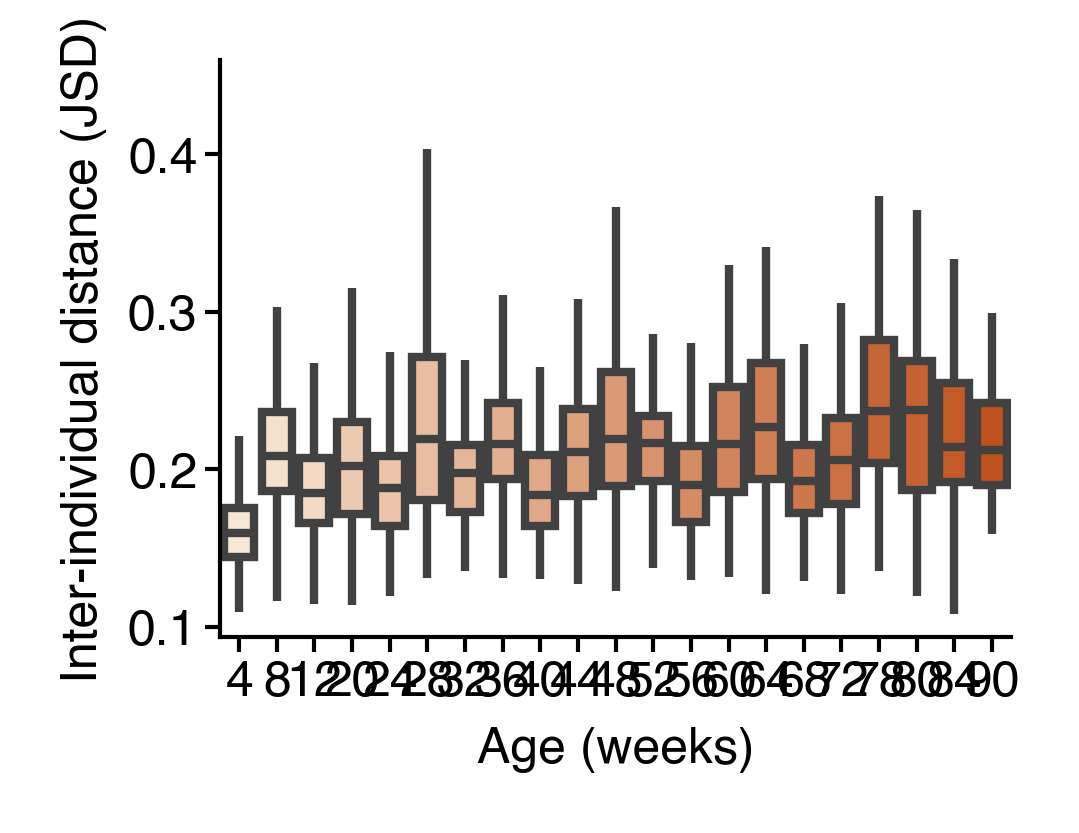

In [80]:
fig = figure(1.7, 1.25)
a = sns.boxplot(data=iid, showfliers=False, showcaps=False, palette=list(onto_color_list))
a.set(xlabel="Age (weeks)", ylabel="Inter-individual distance (JSD)", ylim=(None, 0.46))
sns.despine()
saver(fig, "female_iid-jsd-boxplot");

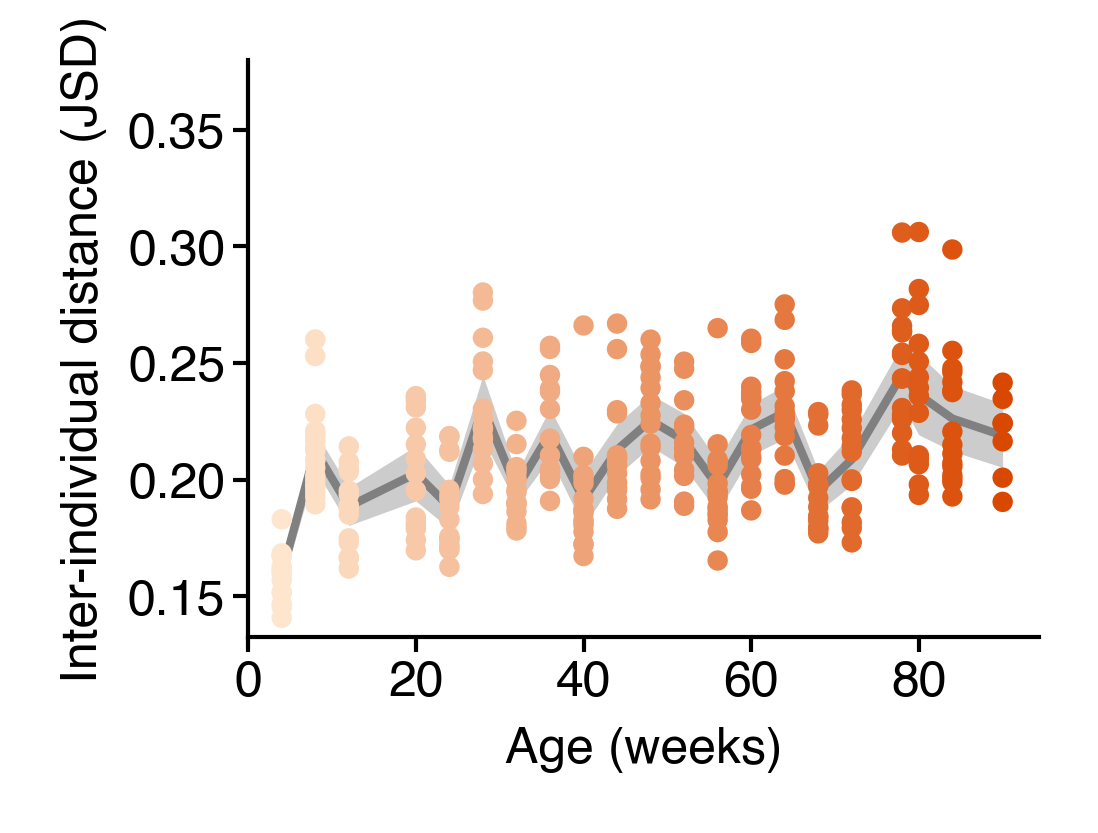

In [78]:
fig = figure(1.7, 1.25)
a = sns.lineplot(
    data=iid_avg_df,
    x="age",
    y="iid",
    zorder=-1,
    color="gray",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se", 2),
)
a = sns.scatterplot(
    data=iid_avg_df,
    x="age",
    y="iid",
    palette=female_cmap,
    hue="age",
    legend=False,
    s=6,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a.set(
    ylim=(None, 0.38),
    xlim=(0, None),
    xlabel="Age (weeks)",
    ylabel="Inter-individual distance (JSD)",
)
sns.despine()
saver(fig, "female_iid-jsd-scatter");

In [81]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in female_df.groupby('age'):
    inter_ind_dists = pdist(_df, metric='cosine')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age)))
iid_df = pd.concat(iid_df)
iid_avg_df = pd.concat(iid_avg_df)

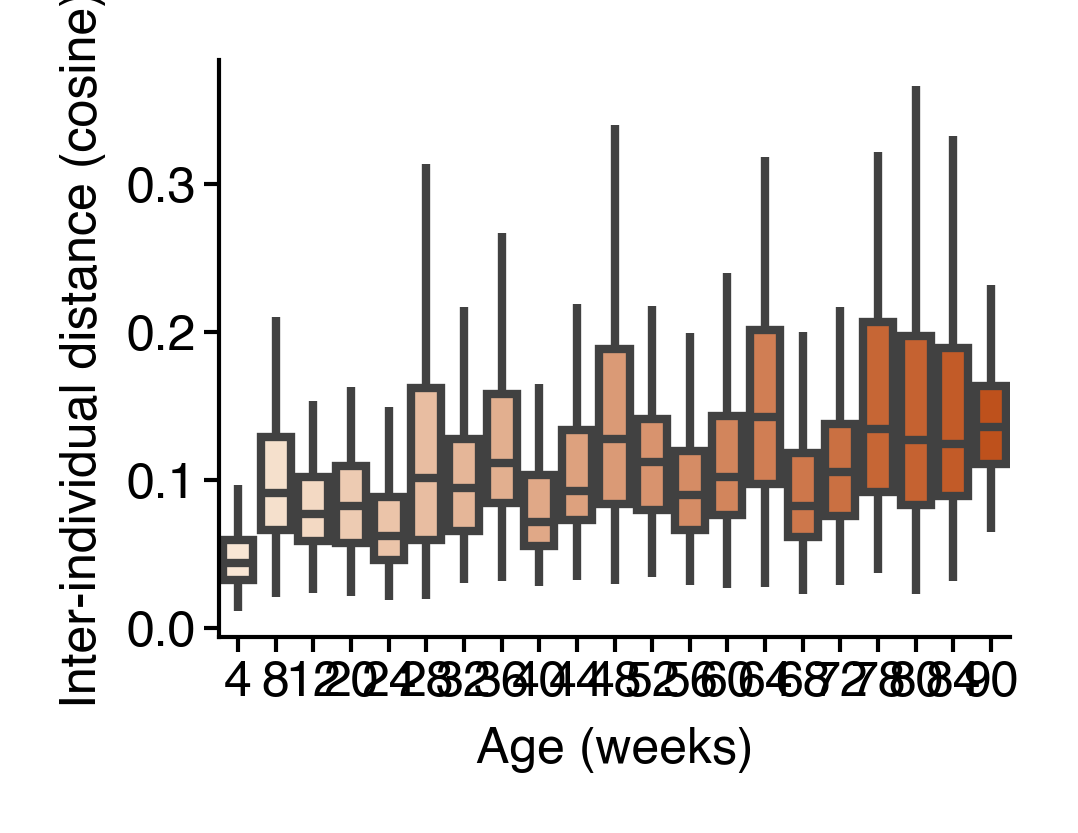

In [82]:
fig = figure(1.7, 1.25)
a = sns.boxplot(data=iid, showfliers=False, showcaps=False, palette=list(onto_color_list))
a.set(xlabel="Age (weeks)", ylabel="Inter-individual distance (cosine)")
sns.despine()
saver(fig, "female_iid-cosine-boxplot");

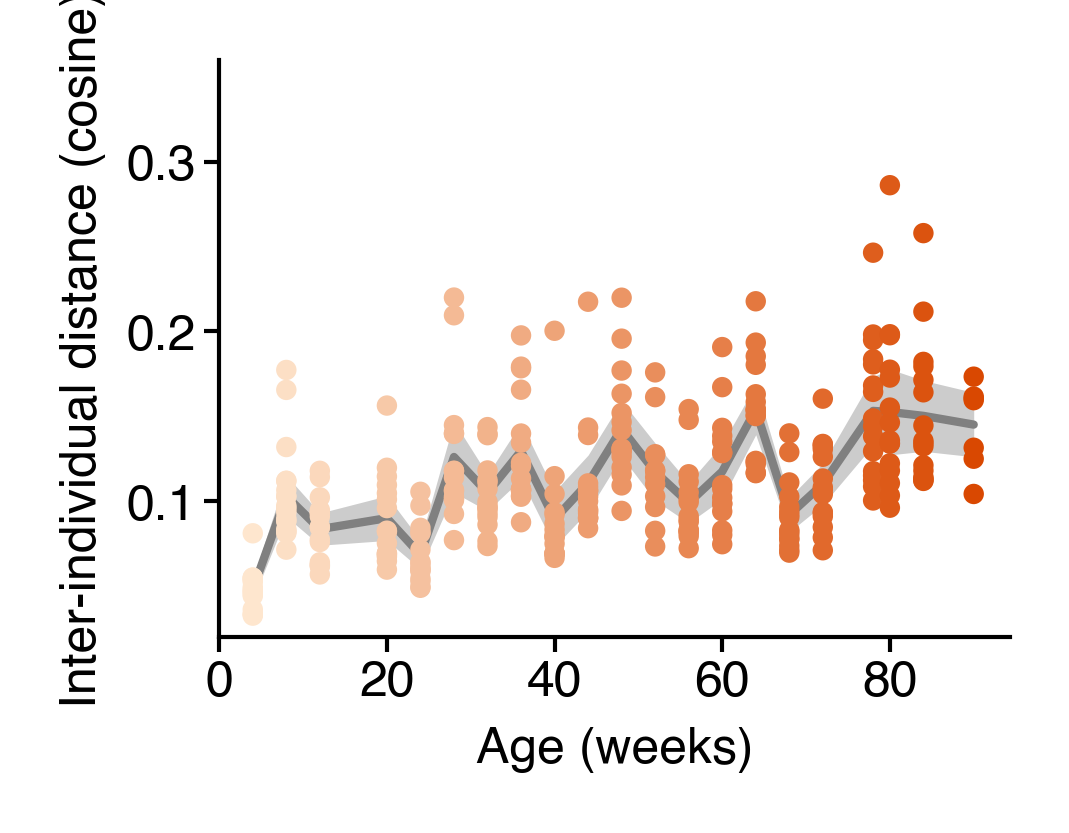

In [83]:
fig = figure(1.7, 1.25)
a = sns.lineplot(
    data=iid_avg_df,
    x="age",
    y="iid",
    zorder=-1,
    color="gray",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se", 2),
)
a = sns.scatterplot(
    data=iid_avg_df,
    x="age",
    y="iid",
    palette=female_cmap,
    hue="age",
    legend=False,
    s=6,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a.set(
    ylim=(None, 0.36),
    xlim=(0, None),
    xlabel="Age (weeks)",
    ylabel="Inter-individual distance (cosine)",
)
sns.despine()
saver(fig, "female_iid-cosine-scatter");

## Rate of change

In [84]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = female_df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize
    norm_diff -= np.nanmin(norm_diff)
    norm_diff /= np.nanmax(norm_diff)

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )

boot_df = pd.DataFrame(boots).T.reset_index()
boot_df = boot_df.melt(id_vars="age")

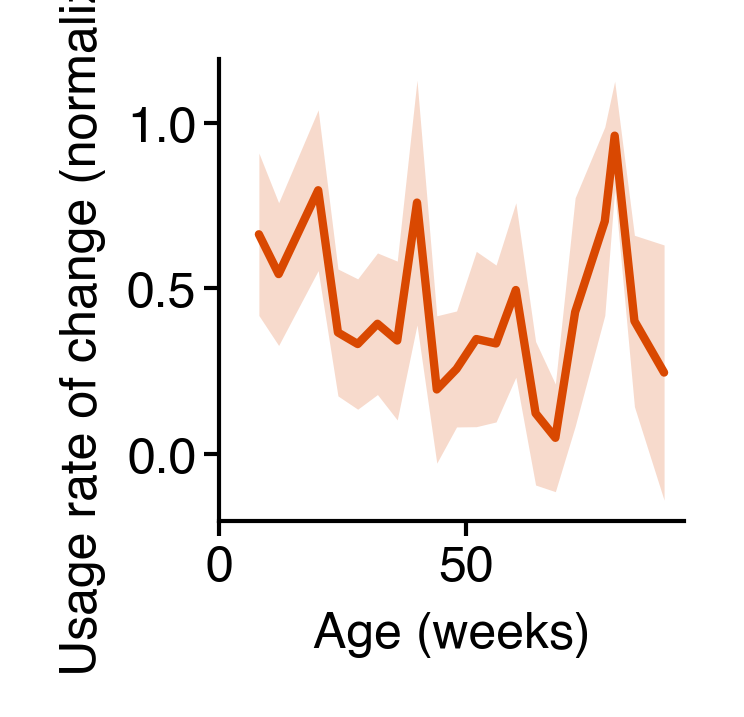

In [87]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=boot_df,
    x="age",
    y="value",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color=female_cmap(256),
)
ax.set(xlim=(0, None), ylabel="Usage rate of change (normalized)", xlabel="Age (weeks)")
sns.despine()
saver(fig, "ontogeny-female-rate-of-change");

In [88]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = female_df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )

boot_df = pd.DataFrame(boots).T.reset_index()
boot_df = boot_df.melt(id_vars="age")

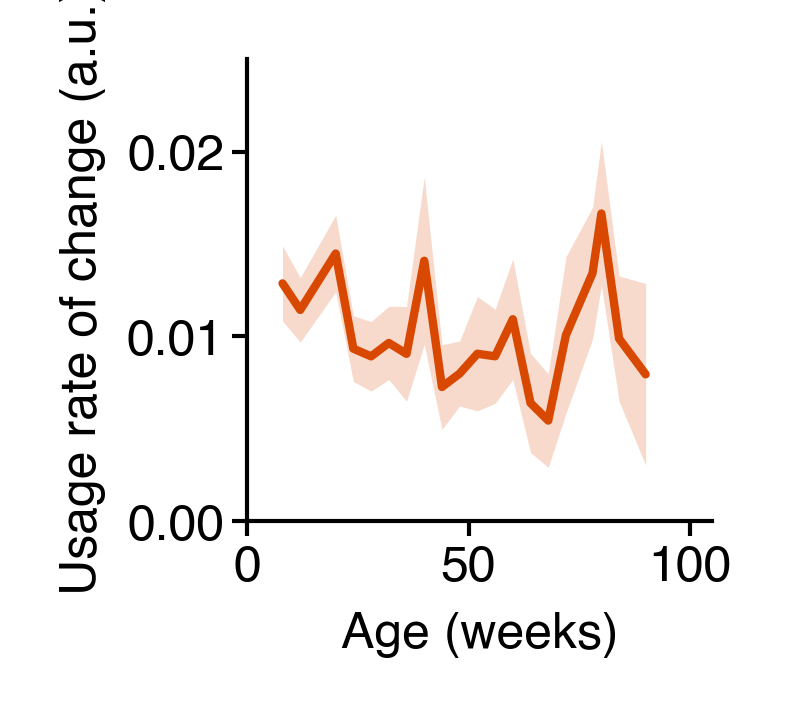

In [92]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=boot_df,
    x="age",
    y="value",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color=female_cmap(256),
)
ax.set(xlim=(0, 105), ylabel="Usage rate of change (a.u.)", xlabel="Age (weeks)", ylim=(0, 0.025))
sns.despine()
saver(fig, "ontogeny-female-rate-of-change-unnormalized");

## NMF

In [93]:
from sklearn.decomposition import NMF

In [100]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = female_df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()

    nmf = NMF(n_components=2, random_state=0, max_iter=4000)
    scores = nmf.fit_transform(avg_usage)
    boots.append(
        pd.DataFrame(scores, index=avg_usage.index)
    )
boot_df = pd.concat(boots).reset_index()
boot_df = boot_df.melt(id_vars="age", var_name='component')

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iteratio

/tmp/ipykernel_6996/1893541900.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.lineplot(data=boot_df, x='age', y='value', hue='component', palette=cc.glasbey_light[5:9], errorbar=('sd', 2), err_kws=dict(lw=0))


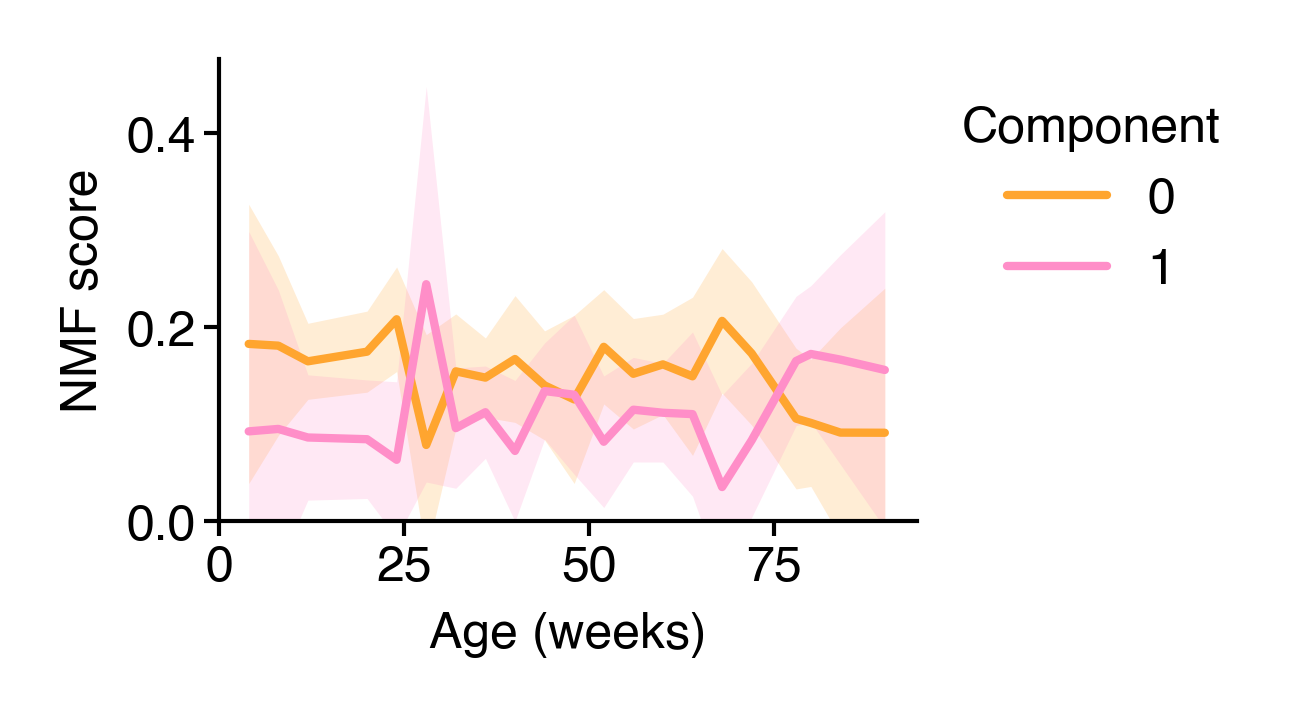

In [101]:
fig = figure(1.5, 1)
ax = sns.lineplot(data=boot_df, x='age', y='value', hue='component', palette=cc.glasbey_light[5:9], errorbar=('sd', 2), err_kws=dict(lw=0))
legend(ax, title="Component")
ax.set(xlabel="Age (weeks)", ylabel="NMF score", xlim=(0, None), ylim=(0, None))
sns.despine()
saver(fig, 'female_nmf-components-with-error');

/tmp/ipykernel_6996/855593993.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.lineplot(data=boot_df, x='age', y='value', hue='component', palette=cc.glasbey_light[5:9], errorbar=None, err_kws=dict(lw=0))


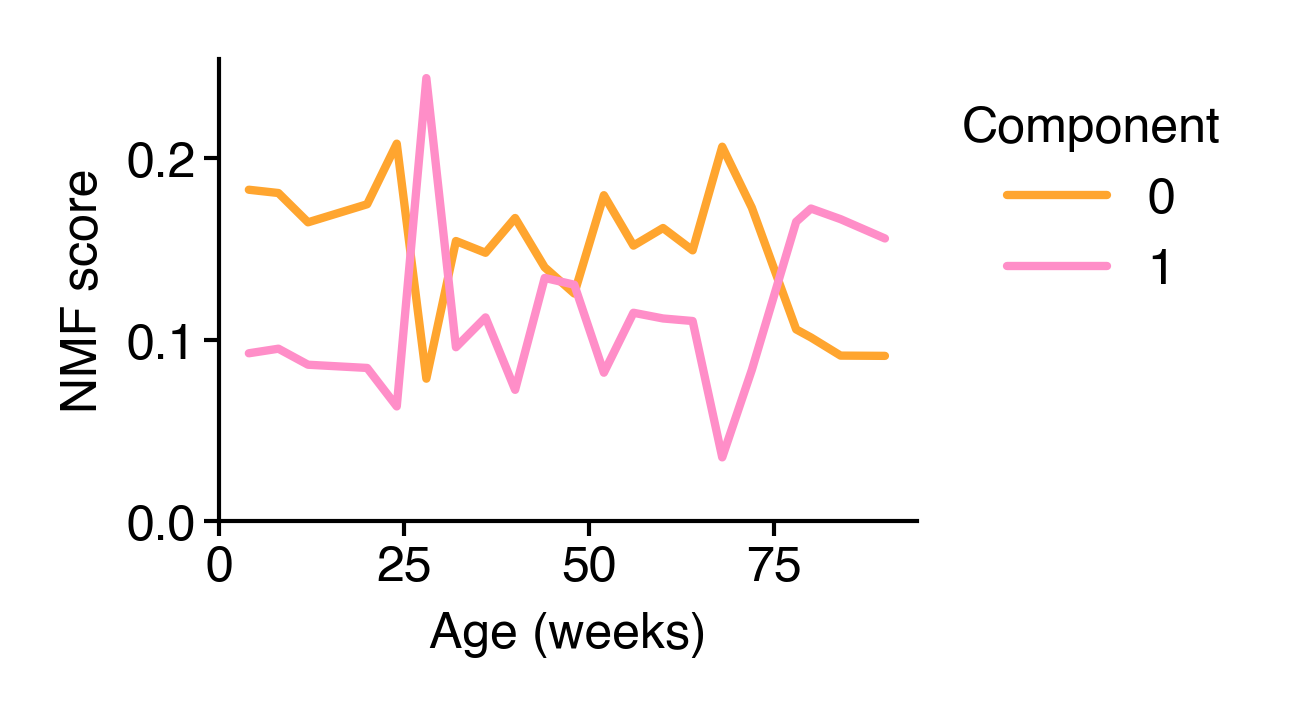

In [102]:
fig = figure(1.5, 1)
ax = sns.lineplot(data=boot_df, x='age', y='value', hue='component', palette=cc.glasbey_light[5:9], errorbar=None, err_kws=dict(lw=0))
legend(ax, title="Component")
ax.set(xlabel="Age (weeks)", ylabel="NMF score", xlim=(0, None), ylim=(0, None))
sns.despine()
saver(fig, 'female_nmf-components-no-error');

## Entropy of syllable usage

In [103]:
from scipy.stats import entropy

In [104]:
ent = pd.Series(entropy(female_df.to_numpy() + 1e-4, axis=1), index=female_df.index)
ent.name = 'entropy'

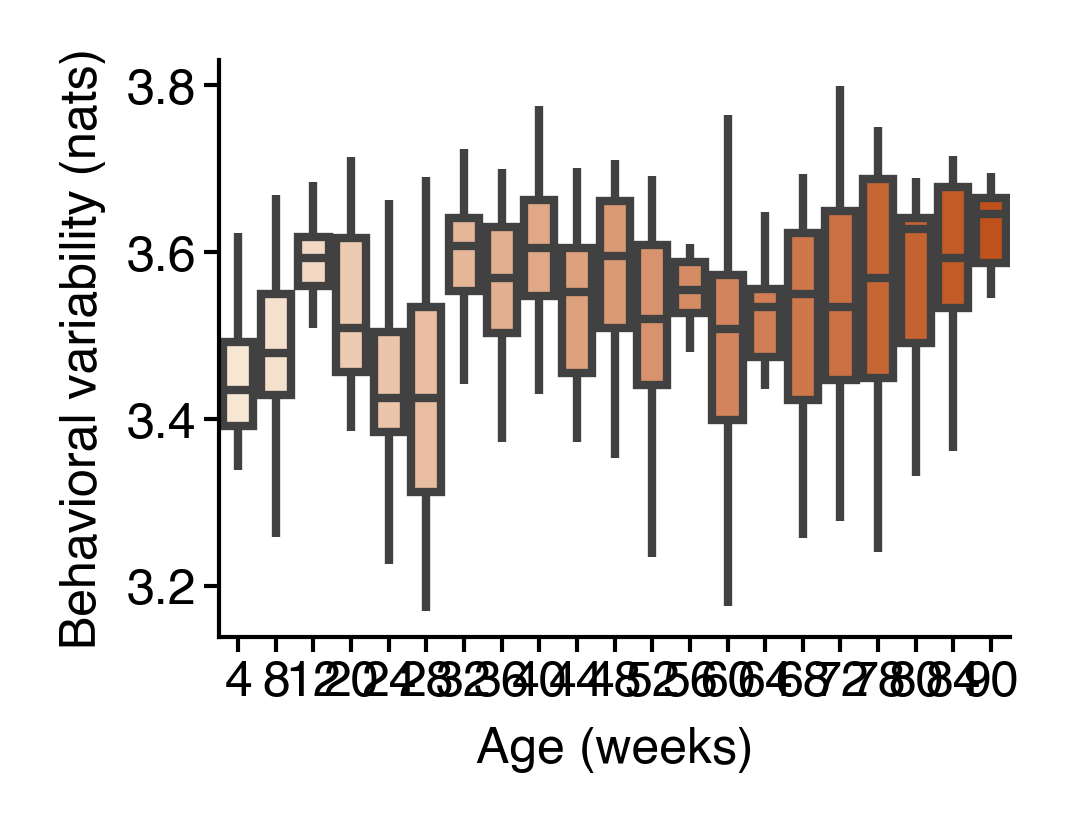

In [105]:
fig = figure(1.7, 1.25)
ax = sns.boxplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    showfliers=False,
    showcaps=False,
    hue="age",
    palette=list(onto_color_list),
    legend=False,
)
ax.set(xlabel='Age (weeks)', ylabel='Behavioral variability (nats)')
sns.despine()
saver(fig, "female_usage-entropy-boxplot");

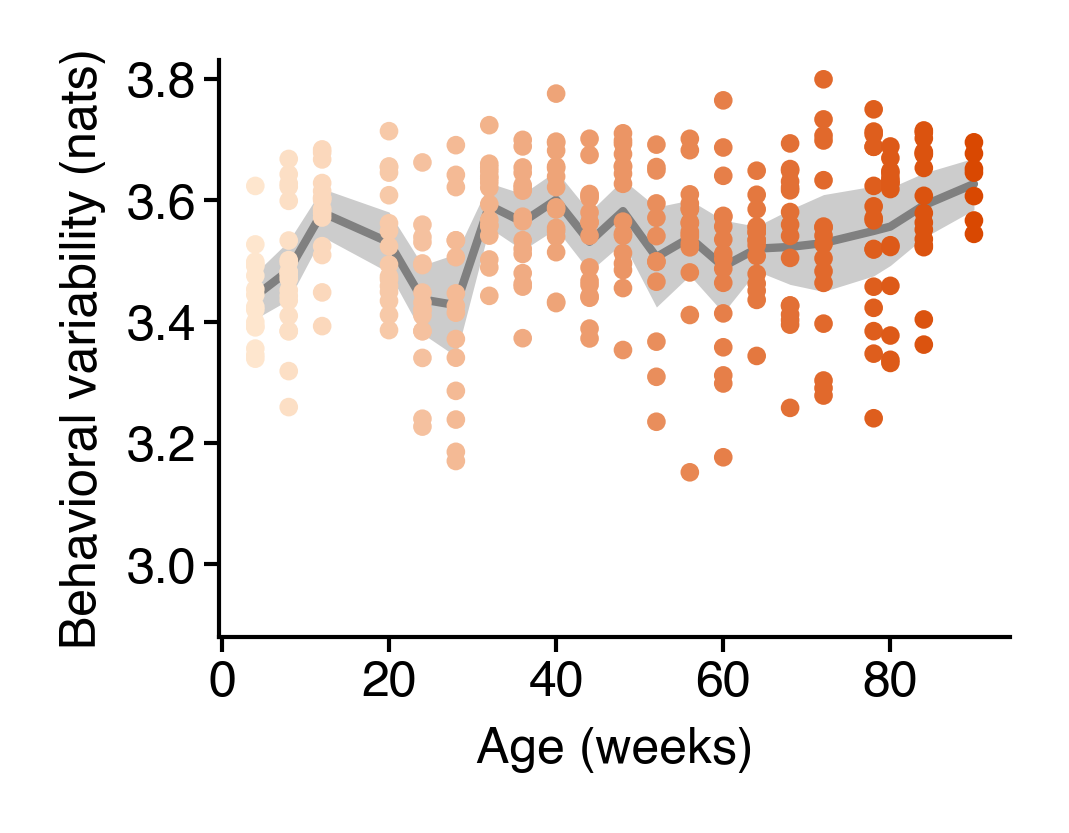

In [110]:
fig = figure(1.7, 1.25)
ax = sns.lineplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    zorder=-1,
    color="gray",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se", 2),
)
ax = sns.scatterplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    hue="age",
    palette=female_cmap,
    linewidths=0,
    s=5,
    legend=False,
)
ax.set(xlabel="Age (weeks)", ylabel="Behavioral variability (nats)", ylim=(2.88, None))
sns.despine()
saver(fig, "female_usage-entropy-scatter");